# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

/Users/isabelmetzger/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters

In [7]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs =1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [9]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 18)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 18) --> (batch, 16, 36)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 36) --> (batch, 8, 36)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Build the inception layer:

![title](img/HAR_inception.png)

In [10]:
with graph.as_default():
    
    # convolution: input to output of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_11 = tf.layers.conv1d(inputs=max_pool_4, filters=36, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_21 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_31 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # average pool: input to middle layer of inception
    # (batch, 8, 36) --> (batch, 8, 36)
    avg_pool_41 = tf.layers.average_pooling1d(inputs=max_pool_4, pool_size=2, strides=1, padding='same')
    
    ## Middle layer of inception
    
    # convolution: middle to out layer of inception (size=2)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv2_22 = tf.layers.conv1d(inputs=conv1_21, filters=36, kernel_size=2, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=4)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv4_32 = tf.layers.conv1d(inputs=conv1_31, filters=36, kernel_size=4, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_42 = tf.layers.conv1d(inputs=avg_pool_41, filters=36, kernel_size=1, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    ## Out layer: Concatenate filters
    # (batch, 8, 4*36)
    inception_out = tf.concat([conv1_11, conv2_22, conv4_32, conv1_42], axis=2)

Now, flatten and pass to the classifier

In [11]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(inception_out, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train the network

In [12]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [13]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.801295 Train acc: 0.193333
Epoch: 1/1000 Iteration: 10 Train loss: 1.775211 Train acc: 0.218333
Epoch: 1/1000 Iteration: 10 Validation loss: 1.753274 Validation acc: 0.250556
Epoch: 1/1000 Iteration: 15 Train loss: 1.743924 Train acc: 0.261667
Epoch: 2/1000 Iteration: 20 Train loss: 1.704157 Train acc: 0.293333
Epoch: 2/1000 Iteration: 20 Validation loss: 1.694645 Validation acc: 0.306111
Epoch: 2/1000 Iteration: 25 Train loss: 1.675011 Train acc: 0.313333
Epoch: 3/1000 Iteration: 30 Train loss: 1.658403 Train acc: 0.291667
Epoch: 3/1000 Iteration: 30 Validation loss: 1.640087 Validation acc: 0.336111
Epoch: 3/1000 Iteration: 35 Train loss: 1.643790 Train acc: 0.320000
Epoch: 4/1000 Iteration: 40 Train loss: 1.619528 Train acc: 0.306667
Epoch: 4/1000 Iteration: 40 Validation loss: 1.583738 Validation acc: 0.347778
Epoch: 4/1000 Iteration: 45 Train loss: 1.595266 Train acc: 0.305000
Epoch: 5/1000 Iteration: 50 Train loss: 1.525659 Train acc: 0.33

Epoch: 41/1000 Iteration: 375 Train loss: 0.262900 Train acc: 0.908333
Epoch: 42/1000 Iteration: 380 Train loss: 0.272523 Train acc: 0.911667
Epoch: 42/1000 Iteration: 380 Validation loss: 0.236540 Validation acc: 0.909445
Epoch: 42/1000 Iteration: 385 Train loss: 0.251948 Train acc: 0.913333
Epoch: 43/1000 Iteration: 390 Train loss: 0.270915 Train acc: 0.896667
Epoch: 43/1000 Iteration: 390 Validation loss: 0.224414 Validation acc: 0.912222
Epoch: 43/1000 Iteration: 395 Train loss: 0.226460 Train acc: 0.931667
Epoch: 44/1000 Iteration: 400 Train loss: 0.273484 Train acc: 0.901667
Epoch: 44/1000 Iteration: 400 Validation loss: 0.213821 Validation acc: 0.916111
Epoch: 44/1000 Iteration: 405 Train loss: 0.246632 Train acc: 0.926667
Epoch: 45/1000 Iteration: 410 Train loss: 0.215442 Train acc: 0.918333
Epoch: 45/1000 Iteration: 410 Validation loss: 0.203813 Validation acc: 0.925000
Epoch: 46/1000 Iteration: 415 Train loss: 0.218560 Train acc: 0.915000
Epoch: 46/1000 Iteration: 420 Train l

Epoch: 82/1000 Iteration: 745 Train loss: 0.130607 Train acc: 0.946667
Epoch: 83/1000 Iteration: 750 Train loss: 0.145225 Train acc: 0.933333
Epoch: 83/1000 Iteration: 750 Validation loss: 0.112398 Validation acc: 0.956111
Epoch: 83/1000 Iteration: 755 Train loss: 0.105189 Train acc: 0.960000
Epoch: 84/1000 Iteration: 760 Train loss: 0.154199 Train acc: 0.925000
Epoch: 84/1000 Iteration: 760 Validation loss: 0.112093 Validation acc: 0.953333
Epoch: 84/1000 Iteration: 765 Train loss: 0.140667 Train acc: 0.950000
Epoch: 85/1000 Iteration: 770 Train loss: 0.115098 Train acc: 0.953333
Epoch: 85/1000 Iteration: 770 Validation loss: 0.111209 Validation acc: 0.955000
Epoch: 86/1000 Iteration: 775 Train loss: 0.117679 Train acc: 0.948333
Epoch: 86/1000 Iteration: 780 Train loss: 0.105230 Train acc: 0.950000
Epoch: 86/1000 Iteration: 780 Validation loss: 0.110780 Validation acc: 0.953889
Epoch: 87/1000 Iteration: 785 Train loss: 0.111871 Train acc: 0.956667
Epoch: 87/1000 Iteration: 790 Train l

Epoch: 123/1000 Iteration: 1110 Train loss: 0.117391 Train acc: 0.940000
Epoch: 123/1000 Iteration: 1110 Validation loss: 0.098295 Validation acc: 0.955555
Epoch: 123/1000 Iteration: 1115 Train loss: 0.081668 Train acc: 0.968333
Epoch: 124/1000 Iteration: 1120 Train loss: 0.129505 Train acc: 0.941667
Epoch: 124/1000 Iteration: 1120 Validation loss: 0.098248 Validation acc: 0.955555
Epoch: 124/1000 Iteration: 1125 Train loss: 0.109395 Train acc: 0.963333
Epoch: 125/1000 Iteration: 1130 Train loss: 0.103736 Train acc: 0.955000
Epoch: 125/1000 Iteration: 1130 Validation loss: 0.097811 Validation acc: 0.955555
Epoch: 126/1000 Iteration: 1135 Train loss: 0.100231 Train acc: 0.955000
Epoch: 126/1000 Iteration: 1140 Train loss: 0.093204 Train acc: 0.960000
Epoch: 126/1000 Iteration: 1140 Validation loss: 0.097669 Validation acc: 0.956111
Epoch: 127/1000 Iteration: 1145 Train loss: 0.095942 Train acc: 0.966667
Epoch: 127/1000 Iteration: 1150 Train loss: 0.106322 Train acc: 0.956667
Epoch: 127/

Epoch: 163/1000 Iteration: 1470 Train loss: 0.117151 Train acc: 0.938333
Epoch: 163/1000 Iteration: 1470 Validation loss: 0.090236 Validation acc: 0.958333
Epoch: 163/1000 Iteration: 1475 Train loss: 0.072218 Train acc: 0.971667
Epoch: 164/1000 Iteration: 1480 Train loss: 0.117408 Train acc: 0.945000
Epoch: 164/1000 Iteration: 1480 Validation loss: 0.090034 Validation acc: 0.958333
Epoch: 164/1000 Iteration: 1485 Train loss: 0.104765 Train acc: 0.958333
Epoch: 165/1000 Iteration: 1490 Train loss: 0.092756 Train acc: 0.966667
Epoch: 165/1000 Iteration: 1490 Validation loss: 0.089728 Validation acc: 0.958889
Epoch: 166/1000 Iteration: 1495 Train loss: 0.082189 Train acc: 0.966667
Epoch: 166/1000 Iteration: 1500 Train loss: 0.087731 Train acc: 0.960000
Epoch: 166/1000 Iteration: 1500 Validation loss: 0.089391 Validation acc: 0.958333
Epoch: 167/1000 Iteration: 1505 Train loss: 0.089817 Train acc: 0.968333
Epoch: 167/1000 Iteration: 1510 Train loss: 0.098934 Train acc: 0.961667
Epoch: 167/

Epoch: 203/1000 Iteration: 1830 Train loss: 0.108851 Train acc: 0.948333
Epoch: 203/1000 Iteration: 1830 Validation loss: 0.080906 Validation acc: 0.962222
Epoch: 203/1000 Iteration: 1835 Train loss: 0.061365 Train acc: 0.976667
Epoch: 204/1000 Iteration: 1840 Train loss: 0.113619 Train acc: 0.950000
Epoch: 204/1000 Iteration: 1840 Validation loss: 0.080414 Validation acc: 0.961111
Epoch: 204/1000 Iteration: 1845 Train loss: 0.094481 Train acc: 0.960000
Epoch: 205/1000 Iteration: 1850 Train loss: 0.089399 Train acc: 0.973333
Epoch: 205/1000 Iteration: 1850 Validation loss: 0.080186 Validation acc: 0.961111
Epoch: 206/1000 Iteration: 1855 Train loss: 0.071707 Train acc: 0.965000
Epoch: 206/1000 Iteration: 1860 Train loss: 0.073759 Train acc: 0.963333
Epoch: 206/1000 Iteration: 1860 Validation loss: 0.079927 Validation acc: 0.962222
Epoch: 207/1000 Iteration: 1865 Train loss: 0.084108 Train acc: 0.966667
Epoch: 207/1000 Iteration: 1870 Train loss: 0.094273 Train acc: 0.956667
Epoch: 207/

Epoch: 243/1000 Iteration: 2190 Train loss: 0.079545 Train acc: 0.956667
Epoch: 243/1000 Iteration: 2190 Validation loss: 0.070740 Validation acc: 0.966667
Epoch: 243/1000 Iteration: 2195 Train loss: 0.051348 Train acc: 0.976667
Epoch: 244/1000 Iteration: 2200 Train loss: 0.105834 Train acc: 0.945000
Epoch: 244/1000 Iteration: 2200 Validation loss: 0.070208 Validation acc: 0.965000
Epoch: 244/1000 Iteration: 2205 Train loss: 0.075817 Train acc: 0.973333
Epoch: 245/1000 Iteration: 2210 Train loss: 0.079651 Train acc: 0.963333
Epoch: 245/1000 Iteration: 2210 Validation loss: 0.069850 Validation acc: 0.966667
Epoch: 246/1000 Iteration: 2215 Train loss: 0.066555 Train acc: 0.970000
Epoch: 246/1000 Iteration: 2220 Train loss: 0.061421 Train acc: 0.968333
Epoch: 246/1000 Iteration: 2220 Validation loss: 0.069455 Validation acc: 0.966667
Epoch: 247/1000 Iteration: 2225 Train loss: 0.063608 Train acc: 0.973333
Epoch: 247/1000 Iteration: 2230 Train loss: 0.077685 Train acc: 0.965000
Epoch: 247/

Epoch: 283/1000 Iteration: 2550 Train loss: 0.082069 Train acc: 0.951667
Epoch: 283/1000 Iteration: 2550 Validation loss: 0.062274 Validation acc: 0.968889
Epoch: 283/1000 Iteration: 2555 Train loss: 0.043699 Train acc: 0.985000
Epoch: 284/1000 Iteration: 2560 Train loss: 0.094790 Train acc: 0.950000
Epoch: 284/1000 Iteration: 2560 Validation loss: 0.061703 Validation acc: 0.969444
Epoch: 284/1000 Iteration: 2565 Train loss: 0.065048 Train acc: 0.970000
Epoch: 285/1000 Iteration: 2570 Train loss: 0.064510 Train acc: 0.968333
Epoch: 285/1000 Iteration: 2570 Validation loss: 0.061778 Validation acc: 0.970556
Epoch: 286/1000 Iteration: 2575 Train loss: 0.054660 Train acc: 0.975000
Epoch: 286/1000 Iteration: 2580 Train loss: 0.056800 Train acc: 0.973333
Epoch: 286/1000 Iteration: 2580 Validation loss: 0.061113 Validation acc: 0.971111
Epoch: 287/1000 Iteration: 2585 Train loss: 0.055749 Train acc: 0.970000
Epoch: 287/1000 Iteration: 2590 Train loss: 0.060942 Train acc: 0.973333
Epoch: 287/

Epoch: 323/1000 Iteration: 2910 Train loss: 0.074002 Train acc: 0.965000
Epoch: 323/1000 Iteration: 2910 Validation loss: 0.055352 Validation acc: 0.973333
Epoch: 323/1000 Iteration: 2915 Train loss: 0.039262 Train acc: 0.986667
Epoch: 324/1000 Iteration: 2920 Train loss: 0.084273 Train acc: 0.956667
Epoch: 324/1000 Iteration: 2920 Validation loss: 0.055163 Validation acc: 0.973333
Epoch: 324/1000 Iteration: 2925 Train loss: 0.052144 Train acc: 0.976667
Epoch: 325/1000 Iteration: 2930 Train loss: 0.057835 Train acc: 0.973333
Epoch: 325/1000 Iteration: 2930 Validation loss: 0.054894 Validation acc: 0.974444
Epoch: 326/1000 Iteration: 2935 Train loss: 0.049105 Train acc: 0.978333
Epoch: 326/1000 Iteration: 2940 Train loss: 0.047057 Train acc: 0.980000
Epoch: 326/1000 Iteration: 2940 Validation loss: 0.054291 Validation acc: 0.975000
Epoch: 327/1000 Iteration: 2945 Train loss: 0.044571 Train acc: 0.976667
Epoch: 327/1000 Iteration: 2950 Train loss: 0.050992 Train acc: 0.978333
Epoch: 327/

Epoch: 363/1000 Iteration: 3270 Train loss: 0.067272 Train acc: 0.963333
Epoch: 363/1000 Iteration: 3270 Validation loss: 0.048724 Validation acc: 0.977222
Epoch: 363/1000 Iteration: 3275 Train loss: 0.029448 Train acc: 0.988333
Epoch: 364/1000 Iteration: 3280 Train loss: 0.067019 Train acc: 0.963333
Epoch: 364/1000 Iteration: 3280 Validation loss: 0.049444 Validation acc: 0.976667
Epoch: 364/1000 Iteration: 3285 Train loss: 0.043869 Train acc: 0.980000
Epoch: 365/1000 Iteration: 3290 Train loss: 0.052218 Train acc: 0.978333
Epoch: 365/1000 Iteration: 3290 Validation loss: 0.049119 Validation acc: 0.978333
Epoch: 366/1000 Iteration: 3295 Train loss: 0.045190 Train acc: 0.976667
Epoch: 366/1000 Iteration: 3300 Train loss: 0.041092 Train acc: 0.980000
Epoch: 366/1000 Iteration: 3300 Validation loss: 0.048557 Validation acc: 0.977778
Epoch: 367/1000 Iteration: 3305 Train loss: 0.041328 Train acc: 0.976667
Epoch: 367/1000 Iteration: 3310 Train loss: 0.044271 Train acc: 0.983333
Epoch: 367/

Epoch: 403/1000 Iteration: 3630 Train loss: 0.052673 Train acc: 0.970000
Epoch: 403/1000 Iteration: 3630 Validation loss: 0.043433 Validation acc: 0.980556
Epoch: 403/1000 Iteration: 3635 Train loss: 0.028004 Train acc: 0.991667
Epoch: 404/1000 Iteration: 3640 Train loss: 0.061553 Train acc: 0.973333
Epoch: 404/1000 Iteration: 3640 Validation loss: 0.043652 Validation acc: 0.978333
Epoch: 404/1000 Iteration: 3645 Train loss: 0.037714 Train acc: 0.981667
Epoch: 405/1000 Iteration: 3650 Train loss: 0.043921 Train acc: 0.978333
Epoch: 405/1000 Iteration: 3650 Validation loss: 0.043447 Validation acc: 0.977778
Epoch: 406/1000 Iteration: 3655 Train loss: 0.039525 Train acc: 0.983333
Epoch: 406/1000 Iteration: 3660 Train loss: 0.033922 Train acc: 0.983333
Epoch: 406/1000 Iteration: 3660 Validation loss: 0.043467 Validation acc: 0.979445
Epoch: 407/1000 Iteration: 3665 Train loss: 0.031954 Train acc: 0.985000
Epoch: 407/1000 Iteration: 3670 Train loss: 0.035924 Train acc: 0.985000
Epoch: 407/

Epoch: 443/1000 Iteration: 3990 Train loss: 0.048429 Train acc: 0.971667
Epoch: 443/1000 Iteration: 3990 Validation loss: 0.037854 Validation acc: 0.982778
Epoch: 443/1000 Iteration: 3995 Train loss: 0.022877 Train acc: 0.986667
Epoch: 444/1000 Iteration: 4000 Train loss: 0.056034 Train acc: 0.976667
Epoch: 444/1000 Iteration: 4000 Validation loss: 0.038626 Validation acc: 0.981667
Epoch: 444/1000 Iteration: 4005 Train loss: 0.035286 Train acc: 0.981667
Epoch: 445/1000 Iteration: 4010 Train loss: 0.039903 Train acc: 0.978333
Epoch: 445/1000 Iteration: 4010 Validation loss: 0.038421 Validation acc: 0.982222
Epoch: 446/1000 Iteration: 4015 Train loss: 0.033913 Train acc: 0.986667
Epoch: 446/1000 Iteration: 4020 Train loss: 0.029074 Train acc: 0.990000
Epoch: 446/1000 Iteration: 4020 Validation loss: 0.038836 Validation acc: 0.981667
Epoch: 447/1000 Iteration: 4025 Train loss: 0.026048 Train acc: 0.993333
Epoch: 447/1000 Iteration: 4030 Train loss: 0.032494 Train acc: 0.985000
Epoch: 447/

Epoch: 483/1000 Iteration: 4350 Train loss: 0.041432 Train acc: 0.981667
Epoch: 483/1000 Iteration: 4350 Validation loss: 0.034313 Validation acc: 0.986111
Epoch: 483/1000 Iteration: 4355 Train loss: 0.016401 Train acc: 0.996667
Epoch: 484/1000 Iteration: 4360 Train loss: 0.043059 Train acc: 0.980000
Epoch: 484/1000 Iteration: 4360 Validation loss: 0.034454 Validation acc: 0.983333
Epoch: 484/1000 Iteration: 4365 Train loss: 0.028172 Train acc: 0.988333
Epoch: 485/1000 Iteration: 4370 Train loss: 0.036994 Train acc: 0.981667
Epoch: 485/1000 Iteration: 4370 Validation loss: 0.034656 Validation acc: 0.982222
Epoch: 486/1000 Iteration: 4375 Train loss: 0.027946 Train acc: 0.991667
Epoch: 486/1000 Iteration: 4380 Train loss: 0.024229 Train acc: 0.988333
Epoch: 486/1000 Iteration: 4380 Validation loss: 0.033622 Validation acc: 0.983333
Epoch: 487/1000 Iteration: 4385 Train loss: 0.024017 Train acc: 0.991667
Epoch: 487/1000 Iteration: 4390 Train loss: 0.028334 Train acc: 0.990000
Epoch: 487/

Epoch: 523/1000 Iteration: 4710 Train loss: 0.039243 Train acc: 0.983333
Epoch: 523/1000 Iteration: 4710 Validation loss: 0.029790 Validation acc: 0.988333
Epoch: 523/1000 Iteration: 4715 Train loss: 0.016927 Train acc: 0.991667
Epoch: 524/1000 Iteration: 4720 Train loss: 0.033889 Train acc: 0.990000
Epoch: 524/1000 Iteration: 4720 Validation loss: 0.029960 Validation acc: 0.986667
Epoch: 524/1000 Iteration: 4725 Train loss: 0.024767 Train acc: 0.988333
Epoch: 525/1000 Iteration: 4730 Train loss: 0.028812 Train acc: 0.990000
Epoch: 525/1000 Iteration: 4730 Validation loss: 0.029687 Validation acc: 0.985556
Epoch: 526/1000 Iteration: 4735 Train loss: 0.027342 Train acc: 0.986667
Epoch: 526/1000 Iteration: 4740 Train loss: 0.021437 Train acc: 0.991667
Epoch: 526/1000 Iteration: 4740 Validation loss: 0.029262 Validation acc: 0.986667
Epoch: 527/1000 Iteration: 4745 Train loss: 0.015178 Train acc: 0.996667
Epoch: 527/1000 Iteration: 4750 Train loss: 0.022588 Train acc: 0.991667
Epoch: 527/

Epoch: 563/1000 Iteration: 5070 Train loss: 0.028416 Train acc: 0.988333
Epoch: 563/1000 Iteration: 5070 Validation loss: 0.026148 Validation acc: 0.988889
Epoch: 563/1000 Iteration: 5075 Train loss: 0.012486 Train acc: 0.998333
Epoch: 564/1000 Iteration: 5080 Train loss: 0.029892 Train acc: 0.991667
Epoch: 564/1000 Iteration: 5080 Validation loss: 0.026509 Validation acc: 0.987778
Epoch: 564/1000 Iteration: 5085 Train loss: 0.020697 Train acc: 0.995000
Epoch: 565/1000 Iteration: 5090 Train loss: 0.023319 Train acc: 0.990000
Epoch: 565/1000 Iteration: 5090 Validation loss: 0.026919 Validation acc: 0.987222
Epoch: 566/1000 Iteration: 5095 Train loss: 0.021150 Train acc: 0.993333
Epoch: 566/1000 Iteration: 5100 Train loss: 0.018285 Train acc: 0.991667
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.026587 Validation acc: 0.987222
Epoch: 567/1000 Iteration: 5105 Train loss: 0.011423 Train acc: 0.996667
Epoch: 567/1000 Iteration: 5110 Train loss: 0.017722 Train acc: 0.991667
Epoch: 567/

Epoch: 603/1000 Iteration: 5430 Train loss: 0.030904 Train acc: 0.983333
Epoch: 603/1000 Iteration: 5430 Validation loss: 0.023189 Validation acc: 0.990000
Epoch: 603/1000 Iteration: 5435 Train loss: 0.011399 Train acc: 1.000000
Epoch: 604/1000 Iteration: 5440 Train loss: 0.022496 Train acc: 0.996667
Epoch: 604/1000 Iteration: 5440 Validation loss: 0.024671 Validation acc: 0.988889
Epoch: 604/1000 Iteration: 5445 Train loss: 0.013975 Train acc: 0.996667
Epoch: 605/1000 Iteration: 5450 Train loss: 0.020905 Train acc: 0.993333
Epoch: 605/1000 Iteration: 5450 Validation loss: 0.024162 Validation acc: 0.989444
Epoch: 606/1000 Iteration: 5455 Train loss: 0.018213 Train acc: 0.991667
Epoch: 606/1000 Iteration: 5460 Train loss: 0.011405 Train acc: 0.996667
Epoch: 606/1000 Iteration: 5460 Validation loss: 0.023681 Validation acc: 0.990000
Epoch: 607/1000 Iteration: 5465 Train loss: 0.010441 Train acc: 0.996667
Epoch: 607/1000 Iteration: 5470 Train loss: 0.014683 Train acc: 0.996667
Epoch: 607/

Epoch: 643/1000 Iteration: 5790 Train loss: 0.025031 Train acc: 0.990000
Epoch: 643/1000 Iteration: 5790 Validation loss: 0.022155 Validation acc: 0.989444
Epoch: 643/1000 Iteration: 5795 Train loss: 0.008781 Train acc: 0.998333
Epoch: 644/1000 Iteration: 5800 Train loss: 0.018704 Train acc: 0.996667
Epoch: 644/1000 Iteration: 5800 Validation loss: 0.022816 Validation acc: 0.990000
Epoch: 644/1000 Iteration: 5805 Train loss: 0.013073 Train acc: 0.996667
Epoch: 645/1000 Iteration: 5810 Train loss: 0.018187 Train acc: 0.993333
Epoch: 645/1000 Iteration: 5810 Validation loss: 0.022337 Validation acc: 0.990000
Epoch: 646/1000 Iteration: 5815 Train loss: 0.015065 Train acc: 0.996667
Epoch: 646/1000 Iteration: 5820 Train loss: 0.011251 Train acc: 0.996667
Epoch: 646/1000 Iteration: 5820 Validation loss: 0.022232 Validation acc: 0.990556
Epoch: 647/1000 Iteration: 5825 Train loss: 0.008606 Train acc: 0.998333
Epoch: 647/1000 Iteration: 5830 Train loss: 0.012965 Train acc: 0.995000
Epoch: 647/

Epoch: 683/1000 Iteration: 6150 Train loss: 0.020913 Train acc: 0.991667
Epoch: 683/1000 Iteration: 6150 Validation loss: 0.020182 Validation acc: 0.992222
Epoch: 683/1000 Iteration: 6155 Train loss: 0.005831 Train acc: 1.000000
Epoch: 684/1000 Iteration: 6160 Train loss: 0.015017 Train acc: 0.993333
Epoch: 684/1000 Iteration: 6160 Validation loss: 0.020589 Validation acc: 0.991667
Epoch: 684/1000 Iteration: 6165 Train loss: 0.010289 Train acc: 0.998333
Epoch: 685/1000 Iteration: 6170 Train loss: 0.014546 Train acc: 0.996667
Epoch: 685/1000 Iteration: 6170 Validation loss: 0.021098 Validation acc: 0.991667
Epoch: 686/1000 Iteration: 6175 Train loss: 0.014937 Train acc: 0.993333
Epoch: 686/1000 Iteration: 6180 Train loss: 0.007756 Train acc: 1.000000
Epoch: 686/1000 Iteration: 6180 Validation loss: 0.020821 Validation acc: 0.991667
Epoch: 687/1000 Iteration: 6185 Train loss: 0.006040 Train acc: 0.998333
Epoch: 687/1000 Iteration: 6190 Train loss: 0.010278 Train acc: 0.998333
Epoch: 687/

Epoch: 723/1000 Iteration: 6510 Train loss: 0.018124 Train acc: 0.991667
Epoch: 723/1000 Iteration: 6510 Validation loss: 0.020301 Validation acc: 0.991667
Epoch: 723/1000 Iteration: 6515 Train loss: 0.005850 Train acc: 1.000000
Epoch: 724/1000 Iteration: 6520 Train loss: 0.012380 Train acc: 1.000000
Epoch: 724/1000 Iteration: 6520 Validation loss: 0.020248 Validation acc: 0.991667
Epoch: 724/1000 Iteration: 6525 Train loss: 0.009699 Train acc: 0.998333
Epoch: 725/1000 Iteration: 6530 Train loss: 0.011897 Train acc: 0.998333
Epoch: 725/1000 Iteration: 6530 Validation loss: 0.020446 Validation acc: 0.990000
Epoch: 726/1000 Iteration: 6535 Train loss: 0.012856 Train acc: 0.995000
Epoch: 726/1000 Iteration: 6540 Train loss: 0.007968 Train acc: 0.996667
Epoch: 726/1000 Iteration: 6540 Validation loss: 0.019082 Validation acc: 0.991667
Epoch: 727/1000 Iteration: 6545 Train loss: 0.004441 Train acc: 1.000000
Epoch: 727/1000 Iteration: 6550 Train loss: 0.007704 Train acc: 1.000000
Epoch: 727/

Epoch: 763/1000 Iteration: 6870 Train loss: 0.015027 Train acc: 0.991667
Epoch: 763/1000 Iteration: 6870 Validation loss: 0.020687 Validation acc: 0.991111
Epoch: 763/1000 Iteration: 6875 Train loss: 0.007015 Train acc: 1.000000
Epoch: 764/1000 Iteration: 6880 Train loss: 0.011704 Train acc: 0.996667
Epoch: 764/1000 Iteration: 6880 Validation loss: 0.021224 Validation acc: 0.991111
Epoch: 764/1000 Iteration: 6885 Train loss: 0.006170 Train acc: 1.000000
Epoch: 765/1000 Iteration: 6890 Train loss: 0.011650 Train acc: 0.996667
Epoch: 765/1000 Iteration: 6890 Validation loss: 0.019926 Validation acc: 0.991667
Epoch: 766/1000 Iteration: 6895 Train loss: 0.009005 Train acc: 0.998333
Epoch: 766/1000 Iteration: 6900 Train loss: 0.005144 Train acc: 0.998333
Epoch: 766/1000 Iteration: 6900 Validation loss: 0.019377 Validation acc: 0.992222
Epoch: 767/1000 Iteration: 6905 Train loss: 0.005114 Train acc: 0.998333
Epoch: 767/1000 Iteration: 6910 Train loss: 0.007418 Train acc: 0.998333
Epoch: 767/

Epoch: 803/1000 Iteration: 7230 Train loss: 0.010624 Train acc: 0.996667
Epoch: 803/1000 Iteration: 7230 Validation loss: 0.019587 Validation acc: 0.991667
Epoch: 803/1000 Iteration: 7235 Train loss: 0.006213 Train acc: 0.998333
Epoch: 804/1000 Iteration: 7240 Train loss: 0.008591 Train acc: 1.000000
Epoch: 804/1000 Iteration: 7240 Validation loss: 0.019597 Validation acc: 0.991111
Epoch: 804/1000 Iteration: 7245 Train loss: 0.005318 Train acc: 1.000000
Epoch: 805/1000 Iteration: 7250 Train loss: 0.006764 Train acc: 0.998333
Epoch: 805/1000 Iteration: 7250 Validation loss: 0.019430 Validation acc: 0.991667
Epoch: 806/1000 Iteration: 7255 Train loss: 0.011025 Train acc: 0.996667
Epoch: 806/1000 Iteration: 7260 Train loss: 0.003398 Train acc: 1.000000
Epoch: 806/1000 Iteration: 7260 Validation loss: 0.020711 Validation acc: 0.991667
Epoch: 807/1000 Iteration: 7265 Train loss: 0.003839 Train acc: 0.998333
Epoch: 807/1000 Iteration: 7270 Train loss: 0.005649 Train acc: 0.998333
Epoch: 807/

Epoch: 843/1000 Iteration: 7590 Train loss: 0.011013 Train acc: 0.996667
Epoch: 843/1000 Iteration: 7590 Validation loss: 0.021221 Validation acc: 0.991111
Epoch: 843/1000 Iteration: 7595 Train loss: 0.003195 Train acc: 1.000000
Epoch: 844/1000 Iteration: 7600 Train loss: 0.006227 Train acc: 1.000000
Epoch: 844/1000 Iteration: 7600 Validation loss: 0.020815 Validation acc: 0.992222
Epoch: 844/1000 Iteration: 7605 Train loss: 0.005416 Train acc: 0.998333
Epoch: 845/1000 Iteration: 7610 Train loss: 0.005040 Train acc: 1.000000
Epoch: 845/1000 Iteration: 7610 Validation loss: 0.020182 Validation acc: 0.991111
Epoch: 846/1000 Iteration: 7615 Train loss: 0.005527 Train acc: 1.000000
Epoch: 846/1000 Iteration: 7620 Train loss: 0.003604 Train acc: 1.000000
Epoch: 846/1000 Iteration: 7620 Validation loss: 0.020288 Validation acc: 0.992222
Epoch: 847/1000 Iteration: 7625 Train loss: 0.002641 Train acc: 1.000000
Epoch: 847/1000 Iteration: 7630 Train loss: 0.004528 Train acc: 0.998333
Epoch: 847/

Epoch: 883/1000 Iteration: 7950 Train loss: 0.006851 Train acc: 1.000000
Epoch: 883/1000 Iteration: 7950 Validation loss: 0.020605 Validation acc: 0.992222
Epoch: 883/1000 Iteration: 7955 Train loss: 0.003381 Train acc: 1.000000
Epoch: 884/1000 Iteration: 7960 Train loss: 0.004297 Train acc: 1.000000
Epoch: 884/1000 Iteration: 7960 Validation loss: 0.020663 Validation acc: 0.992778
Epoch: 884/1000 Iteration: 7965 Train loss: 0.004275 Train acc: 1.000000
Epoch: 885/1000 Iteration: 7970 Train loss: 0.007399 Train acc: 0.998333
Epoch: 885/1000 Iteration: 7970 Validation loss: 0.020384 Validation acc: 0.992222
Epoch: 886/1000 Iteration: 7975 Train loss: 0.004193 Train acc: 1.000000
Epoch: 886/1000 Iteration: 7980 Train loss: 0.002966 Train acc: 1.000000
Epoch: 886/1000 Iteration: 7980 Validation loss: 0.020224 Validation acc: 0.991667
Epoch: 887/1000 Iteration: 7985 Train loss: 0.001781 Train acc: 1.000000
Epoch: 887/1000 Iteration: 7990 Train loss: 0.004116 Train acc: 0.998333
Epoch: 887/

Epoch: 923/1000 Iteration: 8310 Train loss: 0.006727 Train acc: 1.000000
Epoch: 923/1000 Iteration: 8310 Validation loss: 0.019742 Validation acc: 0.992778
Epoch: 923/1000 Iteration: 8315 Train loss: 0.001660 Train acc: 1.000000
Epoch: 924/1000 Iteration: 8320 Train loss: 0.004051 Train acc: 1.000000
Epoch: 924/1000 Iteration: 8320 Validation loss: 0.019694 Validation acc: 0.991667
Epoch: 924/1000 Iteration: 8325 Train loss: 0.003537 Train acc: 1.000000
Epoch: 925/1000 Iteration: 8330 Train loss: 0.003562 Train acc: 1.000000
Epoch: 925/1000 Iteration: 8330 Validation loss: 0.020187 Validation acc: 0.992222
Epoch: 926/1000 Iteration: 8335 Train loss: 0.003837 Train acc: 1.000000
Epoch: 926/1000 Iteration: 8340 Train loss: 0.003020 Train acc: 1.000000
Epoch: 926/1000 Iteration: 8340 Validation loss: 0.019601 Validation acc: 0.992222
Epoch: 927/1000 Iteration: 8345 Train loss: 0.001889 Train acc: 1.000000
Epoch: 927/1000 Iteration: 8350 Train loss: 0.002890 Train acc: 1.000000
Epoch: 927/

Epoch: 963/1000 Iteration: 8670 Train loss: 0.005707 Train acc: 1.000000
Epoch: 963/1000 Iteration: 8670 Validation loss: 0.021116 Validation acc: 0.993333
Epoch: 963/1000 Iteration: 8675 Train loss: 0.002470 Train acc: 1.000000
Epoch: 964/1000 Iteration: 8680 Train loss: 0.005142 Train acc: 0.998333
Epoch: 964/1000 Iteration: 8680 Validation loss: 0.020882 Validation acc: 0.993333
Epoch: 964/1000 Iteration: 8685 Train loss: 0.003879 Train acc: 1.000000
Epoch: 965/1000 Iteration: 8690 Train loss: 0.003560 Train acc: 1.000000
Epoch: 965/1000 Iteration: 8690 Validation loss: 0.021270 Validation acc: 0.993333
Epoch: 966/1000 Iteration: 8695 Train loss: 0.002576 Train acc: 1.000000
Epoch: 966/1000 Iteration: 8700 Train loss: 0.001947 Train acc: 1.000000
Epoch: 966/1000 Iteration: 8700 Validation loss: 0.021457 Validation acc: 0.993333
Epoch: 967/1000 Iteration: 8705 Train loss: 0.000698 Train acc: 1.000000
Epoch: 967/1000 Iteration: 8710 Train loss: 0.001609 Train acc: 1.000000
Epoch: 967/

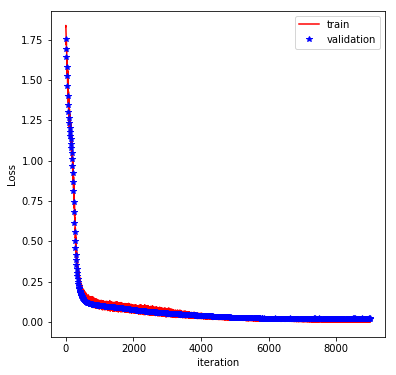

In [14]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

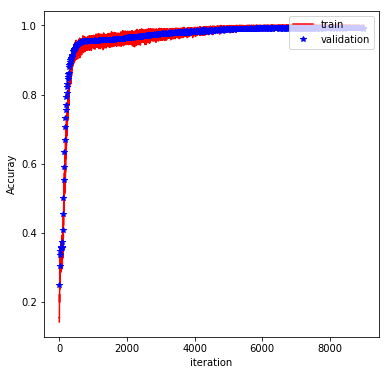

In [15]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [16]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))  
    # Test accuracy: 0.912917

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.912917
